<a href="https://colab.research.google.com/github/Junereals/Practice/blob/main/Amoeba_length_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Segmenting the images
#### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type

#### Adapted from:
**Cellpose code: Carsen Stringer & Marius Pachitariu**

A generalist algorithm for cell and nucleus segmentation.

[Link to the original notebook](https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_Cellpose-SAM.ipynb)

[Link to Paper](https://www.nature.com/articles/s41592-020-01018-x)

[Link to Video talk](https://t.co/JChCsTD0SK?amp=1)

Github Repo: https://github.com/MouseLand/cellpose

Author of the original notebook: Pradeep Rajasekhar

Walter and Eliza Hall Institute of Medical Research, Melbourne, Australia

rajasekhar.p@wehi.edu.au


In [1]:
# @title ##1.Installing Cellpose
!pip install git+https://www.github.com/mouseland/cellpose.git
!pip uninstall -y numpy
!pip install "numpy<2" --force-reinstall
# @markdown ###After running this cell, please restart your session

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-msu60tyz
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-msu60tyz
  Resolved https://www.github.com/mouseland/cellpose.git to commit 6d23968d924fc3b8e419a2d79349888f4b07aa29
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 97.5 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.9.dev5+g6d23968d9-py3-none-any.whl size=212314 sha256=025952d8bcc8bb717f9b0eb3859d782e65df9baf00955bbc7dc5888c60e99dd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-db8vnkhd/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successf

In [1]:
#@markdown ###Importing libraries and checking GPU access
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # Run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

creating new log file
2026-01-19 08:47:27,874 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2026-01-19 08:47:27,874 [INFO] 
cellpose version: 	4.0.9.dev5+g6d23968d9 
platform:       	linux 
python version: 	3.12.12 
torch version:  	2.9.0+cu126
2026-01-19 08:47:28,108 [INFO] ** TORCH CUDA version installed and working. **
2026-01-19 08:47:28,110 [INFO] ** TORCH CUDA version installed and working. **
2026-01-19 08:47:28,111 [INFO] >>>> using GPU (CUDA)
2026-01-19 08:47:30,533 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:13<00:00, 94.3MB/s]


In [2]:
#@markdown ###Run this cell to connect your Google Drive to colab if needed

#@markdown  You will have to allow access or sign in your Google Account.

#@markdown Click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".
# Mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: Error: credential propagation was unsuccessful

In [10]:
# @title 2.Connecting files {"run":"auto"}
# @markdown Change to your folder with file(s) path:
directory = "/content" # @param {"type":"string"}
dir = Path(directory)
if not dir.exists():
  raise FileNotFoundError("Directory does not exist")
# @markdown Change to your image extension:
image_ext = ".tif" #@param [".tif",".png"]

# List all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("No image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

5 images in folder:
100x_114.tif
100x_130.tif
100x_168.tif
100x_169.tif
100x_186.tif


## 3.Processing one image from the folder (parameter selection):
Choose th channels:
- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

Chose the parameters for segmentation:
* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.
* ***diameter*** is an expected cell diameter, chose 200 for larger cell and adjust if needed

your image has shape: (2048, 2880, 3). Assuming channel dimension is last with 3 channels
2026-01-19 08:53:05,306 [INFO] processing image with (2048, 2880) HW, and 3 channels


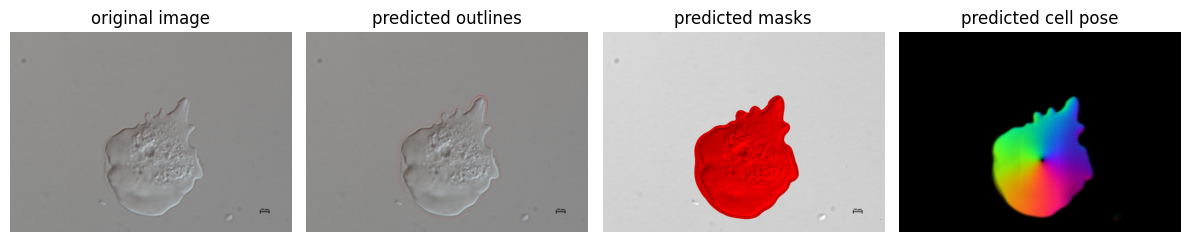

In [13]:
img = io.imread(files[2])
#@markdown Choose parameters for your image
print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  if int(c) > img.shape[-1]:
    assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  if c != 'None':
    selected_channels.append(int(c))



img_selected_channels = np.zeros_like(img)
img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]


flow_threshold = 0.4 #@param
cellprob_threshold = -10.0 #@param
tile_norm_blocksize = 0 #@param
diameter = 150 #@param
masks, flows, styles = model.eval(img_selected_channels, batch_size=32,diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()

In [ ]:
#@markdown Run this if you want to save the mask
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img_selected_channels, batch_size=32,diameter=200, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

  0%|          | 0/1 [00:00<?, ?it/s]

2026-01-18 23:58:19,247 [INFO] processing image with (2048, 2880) HW, and 3 channels


100%|██████████| 1/1 [00:23<00:00, 23.27s/it]


## 4.Running the segmentation on a folder of images

In [14]:
#@markdown If you have many large images, it's better to run them as a loop over images.

#@markdown The saved masks will be visible in files section on the left.
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,diameter=diameter,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

  0%|          | 0/5 [00:00<?, ?it/s]

2026-01-19 08:55:01,746 [INFO] processing image with (2048, 2880) HW, and 3 channels


 20%|██        | 1/5 [00:14<00:58, 14.53s/it]

2026-01-19 08:55:16,276 [INFO] processing image with (2048, 2880) HW, and 3 channels


 40%|████      | 2/5 [00:33<00:51, 17.18s/it]

2026-01-19 08:55:35,301 [INFO] processing image with (2048, 2880) HW, and 3 channels


 60%|██████    | 3/5 [00:55<00:38, 19.47s/it]

2026-01-19 08:55:57,490 [INFO] processing image with (2048, 2880) HW, and 3 channels


 80%|████████  | 4/5 [01:04<00:15, 15.13s/it]

2026-01-19 08:56:05,967 [INFO] processing image with (2048, 2880) HW, and 3 channels


100%|██████████| 5/5 [01:21<00:00, 16.32s/it]


#II. Length and width measurement

In [15]:
#@title ###1.Downloading the libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, measure, morphology, draw, filters
from scipy.spatial import ConvexHull, distance
from scipy import ndimage
import networkx as nx
from collections import deque
from skimage.measure import approximate_polygon
import pandas as pd

2026-01-19 08:56:50,631 [INFO] NumExpr defaulting to 2 threads.


In [20]:
# @title ###2.Connecting files and rescaling if needed
# @markdown Path to the mask image:
masks_path = '' #@param {"type":"string"}
# @markdown Scaling coeficient (Write 1 for no resizing):
scale_coeff = 1 #@param {"type":"number"}
dir = Path(masks_path)
if not dir.exists():
  raise FileNotFoundError("Directory does not exist")
# @markdown Change to your masks image extension:
image_ext = ".tif" #@param [".tif",".png"]

# List all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" in f.name])

if(len(files)==0):
  raise FileNotFoundError("No masks files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")
for f in files:
  print(f.name)

4 images in folder:
100x_114_masks.tif
100x_130_masks.tif
100x_168_masks.tif
100x_186_masks.tif


In [17]:
#@markdown Adding functions
def binary_image_transform_area(binary_image):
    """Transformes non-object pixels to 0 and object ones to 1, counts object area

        Input: image as np.array

        Output: (binary image, area)"""
    area = 0
    for i in range(len(binary_image)):
        for b in range(len(binary_image[i])):
            if binary_image[i][b]!=0:
                binary_image[i][b]=1
                area+=1
    return (binary_image, area)
def find_approximate_contour(binary_image, tolerance=0.5):
    """Finds the longest contour and aproximates it
        Input: binary image, aproximation toleranse
        Output: contour"""
    # Finding contours
    contours = measure.find_contours(binary_image, 0.5)
    if len(contours)==0:
      raise ValueError(f"Mask is empty in {f.name}. \n Try testing the segmentation of this picture in the I.3 ")
    #Choosing the longest one
    longest_contour = max(contours, key=len)
    contour_approx = approximate_polygon(longest_contour, tolerance=tolerance)
    return contour_approx
def is_line_inside_object(point1, point2, binary_image):
    """Checks if the line is inside the object on binary image
        Input: start point, end poin, image
        Output: True/False"""
    # Changing coordinates (y,x) to (row, col)
    r1, c1 = int(point1[0]), int(point1[1])
    r2, c2 = int(point2[0]), int(point2[1])

    # Drawing the lines
    rr, cc = draw.line(r1, c1, r2, c2)

    #See if the lines are inside
    valid_mask = (rr >= 0) & (rr < binary_image.shape[0]) & (cc >= 0) & (cc < binary_image.shape[1])

    if not np.all(valid_mask):
        return False

    #See if all points of the line are inside
    return np.all(binary_image[rr, cc] == 1)
def find_length(contour_approx, binary_image):
    """Find the longest diametr of the object strictly inside the contour
        Input: contour
        Output: (length, length points coordinates)"""
    n = len(contour_approx)
    max_length = 0
    best_pair = None
    for i in range(n):
        for j in range(i+1, n):
            point1 = contour_approx[i]
            point2 = contour_approx[j]
        # See if the line is inside of the object
            if is_line_inside_object(point1, point2, binary_image):
                length = np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)
                if length > max_length:
                    max_length = length
                    best_pair = (point1, point2)
    return (max_length, best_pair)
def find_perpendicular_width(img, point, direction, max_search_dist=100):
    """
    Find width in the given direction from the starting point

    Args:
        img: binary image
        point: starting point (y,x)
        direction: unit vector (y,x)
        max_search_dist: max distance for searching

    Returns:
        width: width of the object
        (start_point, end_point): points of the width line
    """
    point = np.array(point, dtype=int)
    direction = np.array(direction)

    pos_dist = 0
    for d in range(1, max_search_dist):
        test_point_p = point + d * direction
        if not is_line_inside_object(point,test_point_p,img):
            pos_dist = d-1
            end_point=test_point_p
            break
    else:
        pos_dist = max_search_dist - 1

    neg_dist = 0
    for d in range(1, max_search_dist):
        test_point_n = point - d * direction
        if not is_line_inside_object(point,test_point_n,img):
            neg_dist = d - 1
            start_point = test_point_n
            break
    else:
        neg_dist = max_search_dist - 1

    total_width = pos_dist + neg_dist + 1


    return total_width, start_point, end_point
def find_length_and_width_within(binary_image,coeff,ratio,tolerance=0.5):
    """Simple pipeline for finding object's measurements"""
    binary_image, area = binary_image_transform_area(binary_image)
    contour = find_approximate_contour(binary_image)
    length, (p2, p1) = find_length(contour,binary_image)
    main_axis = p2 - p1
    num_steps = int(length)
    max_width = 0
    best_width_points = None
    perpendicular_axis = np.array([-main_axis[1], main_axis[0]])
    perpendicular_axis_unit = perpendicular_axis / np.linalg.norm(perpendicular_axis)

    for t in np.linspace(0, 1, num_steps):
        current_point = p1 + t * main_axis
    #Searching for the max width
        width, start_pt, end_pt = find_perpendicular_width(binary_image, current_point, perpendicular_axis_unit, int(length))
        if width > max_width:
            max_width = width
            best_width_points = (start_pt, end_pt)
    result = {
        'area': area*coeff**(-2),
        'area (µm)': (area*coeff**(-2))*ratio**2,
        'contour':contour,
        'approximation (px)': tolerance*coeff**(-1),
        'approximation (px)': tolerance*ratio*coeff**(-1),
        'length_points': np.array([p1,p2]),
        'length': (length*coeff**-1),
        'length (µm)': (length*coeff**-1)*ratio,
        'width_points': np.array([best_width_points[0], best_width_points[1]]),
        'width': (max_width*coeff**-1),
        'width(µm)': (max_width*coeff**-1)*ratio}
    return result
def visualize_results(original_image, binary_image, results):
    """Visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Original image
    axes[0,0].imshow(original_image, cmap='gray')
    axes[0,0].set_title('Original image')
    axes[0,0].axis('off')

    # Binary image
    axes[0,1].imshow(binary_image, cmap='gray')
    axes[0,1].set_title('Binary image')
    axes[0,1].axis('off')

    # Contours
    contour = results['contour']
    axes[1,0].imshow(binary_image, cmap='gray')
    axes[1,0].plot(contour[:, 1], contour[:, 0], 'r-', linewidth=1)
    axes[1,0].set_title('Contour of the object')
    axes[1,0].axis('off')

    # Length and width
    axes[1,1].imshow(binary_image, cmap='gray')
    if results['length_points'] is not None:
        points = results['length_points']
        axes[1,1].plot([points[0,1], points[1,1]], [points[0,0], points[1,0]],
                      'b-', linewidth=3, label=f'Length: {results["length"]:.2f}px')
        axes[1,1].scatter(points[:,1], points[:,0], c='red', s=50)
    if results['width_points'] is not None:
        points = results['width_points']
        axes[1,1].plot([points[0,1], points[1,1]], [points[0,0], points[1,0]],
                        'g', linewidth=3, label=f'Width: {results["width"]:.2f}px')
    axes[1,1].scatter(points[:,1], points[:,0], c='green', s=50)
    axes[1,1].set_title('Length and width after aproximation')
    axes[1,1].legend()
    axes[1,1].axis('off')

In [21]:
#@title ###3.Proccessing the masks
#@markdown Insert scale ratio to return µm values:
µm_to_nm_ratio = 1 #@param
#@markdown Approximation tolerance
tolerance = 0.5 #@param
all_results = []
for f in files:
  im = Image.open(f)
  (width, height) = (int(im.width//(scale_coeff**(-1))), int(im.height//(scale_coeff**(-1))))
  im_resized = im.resize((width, height))
  binary_image = np.array(im_resized)
  resulted_l_w = find_length_and_width_within(binary_image,scale_coeff,µm_to_nm_ratio,tolerance=tolerance)
  result = {"file_name":f.name.rstrip("_masks"+image_ext)+image_ext,**resulted_l_w}
  all_results.append(result)

In [22]:
#@title ###4.Downloading the exel file with results
df = pd.DataFrame(all_results)
df = df.drop(columns=['contour'])
#@markdown Choose the file name (optional)
file_name = "data.xlsx" # @param {"type":"string"}
df.to_excel(file_name,index=False)
print(f'File {file_name} is created. See files in the left panel.')

File data.xlsx is created. See files in the left panel.


#III.Visualize the results

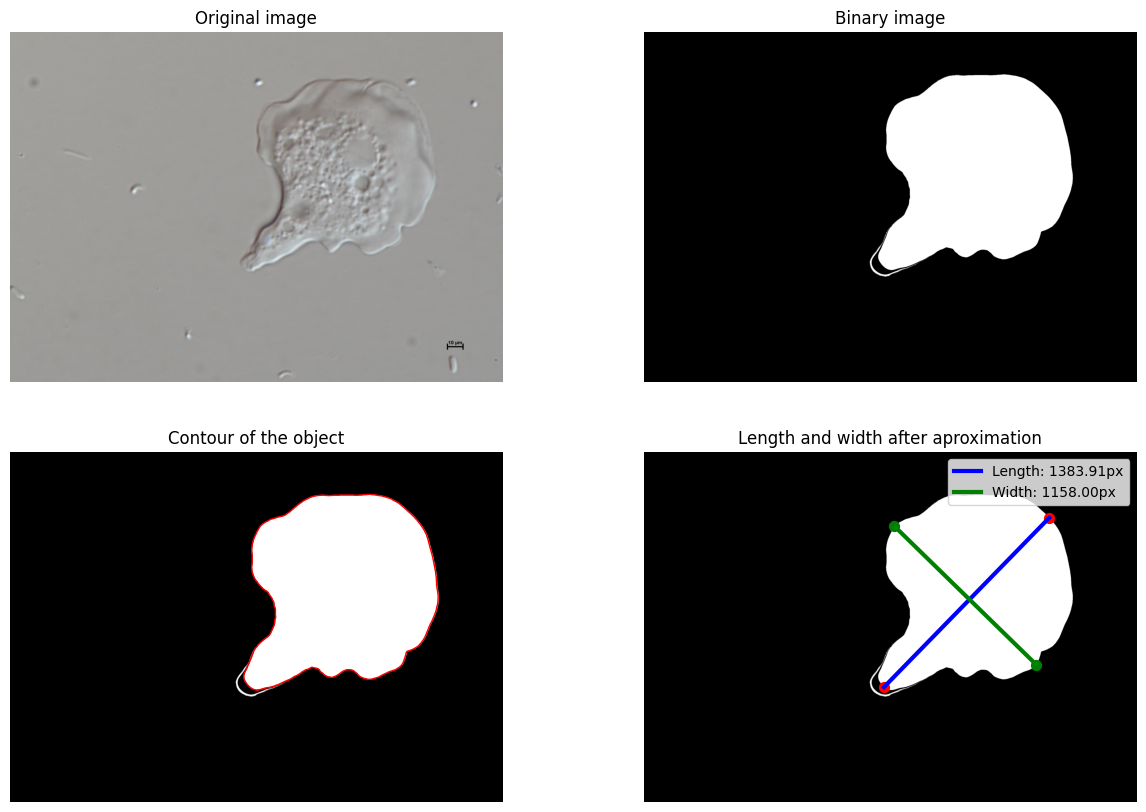

In [ ]:

#@markdown Insert the name of the image you want to visualize:
name = "100x_138.tif" # @param {"type":"string"}
image = Image.open(masks_path+'/'+name)
binary_image_mask,_ = binary_image_transform_area(np.array(Image.open(masks_path+'/'+name.rstrip(image_ext)+'_masks'+image_ext)))
result_for_vis = list(filter(lambda x: x['file_name']==name,all_results))
visualize_results(image, binary_image_mask,result_for_vis[0])